# DIMENSIONALITY REDUCTION
Many machine learning problems involve thousands or even millions of features for each training instance. Not only do all these features make training extremely slow, but they can also make it much harder to find a good solution, as you will see. This problem is often referred to as the curse of dimensionality.

Fortunately, in real-world problems, it is often possible to reduce the number of features considerably, turning an intractable problem into a tractable one. For example, consider the MNIST images (introduced in Chapter 3): the pixels on the image borders are almost always white, so you could completely drop these pixels from the training set without losing much information. As we saw in the previous chapter, (Figure 7-6) confirms that these pixels are utterly unimportant for the classification task. Additionally, two neighboring pixels are often highly correlated: if you merge them into a single pixel (e.g., by taking the mean of the two pixel intensities), you will not lose much information.

WARNING
Reducing dimensionality does cause some information loss, just like compressing an image to JPEG can degrade its quality, so even though it will speed up training, it may make your system perform slightly worse. It also makes your pipelines a bit more complex and thus harder to maintain. Therefore, I recommend you first try to train your system with the original data before considering using dimensionality reduction. In some cases, reducing the dimensionality of the training data may filter out some noise and unnecessary details and thus result in higher performance, but in general it won’t; it will just speed up training.

Apart from speeding up training, dimensionality reduction is also extremely useful for data visualization. Reducing the number of dimensions down to two (or three) makes it possible to plot a condensed view of a high-dimensional training set on a graph and often gain some important insights by visually detecting patterns, such as clusters. Moreover, data visualization is essential to communicate your conclusions to people who are not data scientists—in particular, decision makers who will use your results.

In this chapter we will first discuss the curse of dimensionality and get a sense of what goes on in high-dimensional space. Then we will consider the two main approaches to dimensionality reduction (projection and manifold learning), and we will go through three of the most popular dimensionality reduction techniques: PCA, random projection, and locally linear embedding (LLE).

# THE CURSE OF DIMENSIONALITY
We are so used to living in three dimensions that our intuition fails us when we try to imagine a high-dimensional space. Even a basic 4D hypercube is incredibly hard to picture in our minds (see Figure 8-1), let alone a 200-dimensional ellipsoid bent in a 1,000-dimensional space.

Figure 8-1. Point, segment, square, cube, and tesseract (0D to 4D hypercubes)⁠
![dimensions](../images/dimensions.png)


It turns out that many things behave very differently in high-dimensional space. For example, if you pick a random point in a unit square (a 1 × 1 square), it will have only about a 0.4% chance of being located less than 0.001 from a border (in other words, it is very unlikely that a random point will be “extreme” along any dimension). But in a 10,000-dimensional unit hypercube, this probability is greater than 99.999999%. Most points in a high-dimensional hypercube are very close to the border.

Here is a more troublesome difference: if you pick two points randomly in a unit square, the distance between these two points will be, on average, roughly 0.52. If you pick two random points in a 3D unit cube, the average distance will be roughly 0.66. But what about two points picked randomly in a 1,000,000-dimensional unit hypercube? The average distance, believe it or not, will be about 408.25, rougly $\sqrt{\frac{1000000}{6}}$. This is counterintuitive: how can two points be so far apart when they both lie within the same unit hypercube? Well, there’s just plenty of space in high dimensions. As a result, high-dimensional datasets are at risk of being very sparse: most training instances are likely to be far away from each other. This also means that a new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions, since they will be based on much larger extrapolations. In short, the more dimensions the training set has, the greater the risk of overfitting it.

In theory, one solution to the curse of dimensionality could be to increase the size of the training set to reach a sufficient density of training instances. Unfortunately, in practice, the number of training instances required to reach a given density grows exponentially with the number of dimensions. With just 100 features—significantly fewer than in the MNIST problem—all ranging from 0 to 1, you would need more training instances than atoms in the observable universe in order for training instances to be within 0.1 of each other on average, assuming they were spread out uniformly across all dimensions.

# MAIN APPROACHES FOR DIMENSIONALITY REDUCTION
Before we dive into specific dimensionality reduction algorithms, let’s take a look at the two main approaches to reducing dimensionality: projection and manifold learning.

# PROJECTION
In most real-world problems, training instances are not spread out uniformly across all dimensions. Many features are almost constant, while others are highly correlated (as discussed earlier for MNIST). As a result, all training instances lie within (or close to) a much lower-dimensional subspace of the high-dimensional space. This sounds very abstract, so let’s look at an example. In Figure 8-2 you can see a 3D dataset represented by small spheres.



In [2]:

# Let's generate a small 3D dataset. It's an oval shape, rotated in 3D space, with points distributed unevenly, and with quite a lot of noise:

# extra code

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

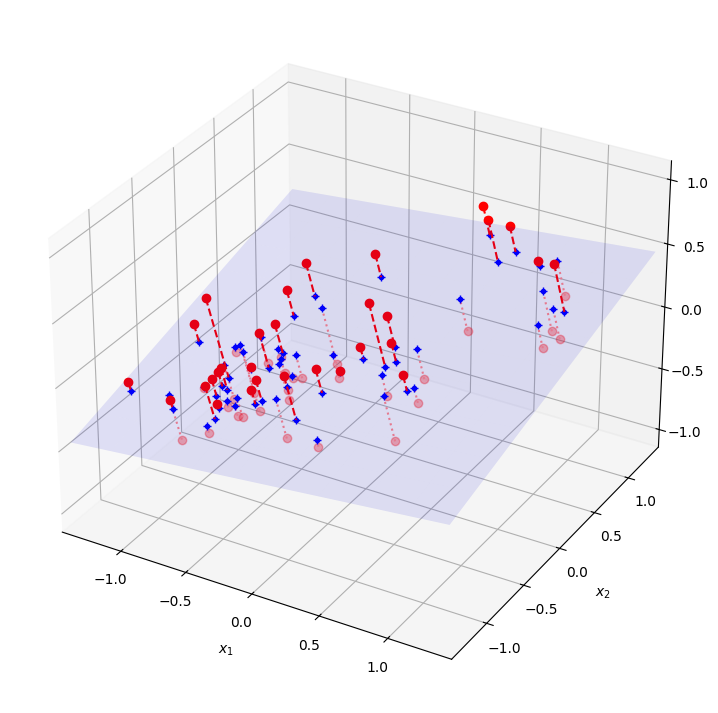

In [3]:
# extra code – this cell generates and saves Figure 8–2

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")


def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])


set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

plt.show()

# Figure 8-2. A 3D dataset lying close to a 2D subspace


Notice that all training instances lie close to a plane: this is a lower-dimensional (2D) subspace of the higher-dimensional (3D) space. If we project every training instance perpendicularly onto this subspace (as represented by the short dashed lines connecting the instances to the plane), we get the new 2D dataset shown in Figure 8-3. Ta-da! We have just reduced the dataset’s dimensionality from 3D to 2D. Note that the axes correspond to new features $z_1$ and $z_2$: they are the coordinates of the projections on the plane.

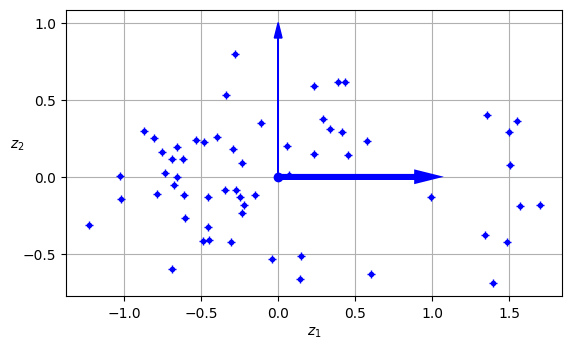

In [4]:
# extra code – this cell generates and saves Figure 8–3

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True)

# Figure 8-3. The new 2D dataset after projection

# MANIFOLD LEARNING
However, projection is not always the best approach to dimensionality reduction. In many cases the subspace may twist and turn, such as in the famous Swiss roll toy dataset represented in Figure 8-4.

In [5]:
from sklearn.datasets import make_swiss_roll

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

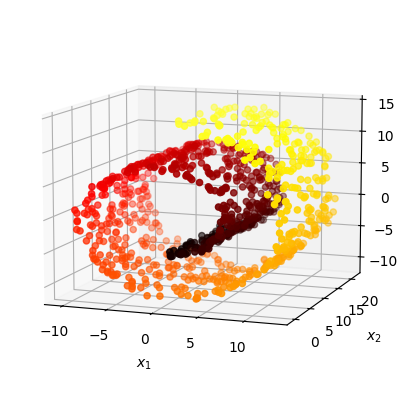

In [6]:
# extra code – this cell generates and saves Figure 8–4

from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes)
plt.show()

# Figure 8-4. Swiss roll dataset

Simply projecting onto a plane (e.g., by dropping $x_3$) would squash different layers of the Swiss roll together, as shown on the left side of Figure 8-5. What you probably want instead is to unroll the Swiss roll to obtain the 2D dataset on the right side of Figure 8-5.

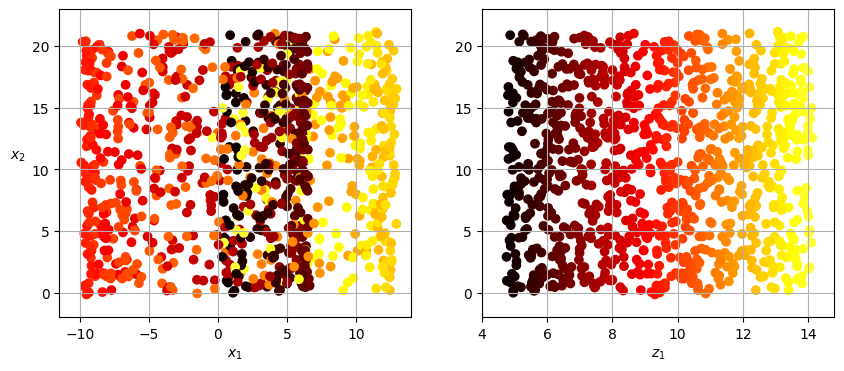

In [7]:
# extra code – this cell generates and saves plots for Figure 8–5

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", labelpad=10, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis([4, 14.8, axes[2], axes[3]])
plt.xlabel("$z_1$")
plt.grid(True)

plt.show()

# Figure 8-5. Squashing by projecting onto a plane (left) versus unrolling the Swiss roll (right)

The Swiss roll is an example of a 2D manifold. Put simply, a 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space. More generally, a $d$-dimensional manifold is a part of an $n$-dimensional space (where $d < n$) that locally resembles a $d$-dimensional hyperplane. In the case of the Swiss roll, $d = 2$ and $n = 3$: it locally resembles a 2D plane, but it is rolled in the third dimension.

Many dimensionality reduction algorithms work by modeling the manifold on which the training instances lie; this is called manifold learning. It relies on the manifold assumption, also called the manifold hypothesis, which holds that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold. This assumption is very often empirically observed.

Once again, think about the MNIST dataset: all handwritten digit images have some similarities. They are made of connected lines, the borders are white, and they are more or less centered. If you randomly generated images, only a ridiculously tiny fraction of them would look like handwritten digits. In other words, the degrees of freedom available to you if you try to create a digit image are dramatically lower than the degrees of freedom you have if you are allowed to generate any image you want. These constraints tend to squeeze the dataset into a lower-dimensional manifold.

The manifold assumption is often accompanied by another implicit assumption: that the task at hand (e.g., classification or regression) will be simpler if expressed in the lower-dimensional space of the manifold. For example, in the top row of Figure 8-6 the Swiss roll is split into two classes: in the 3D space (on the left) the decision boundary would be fairly complex, but in the 2D unrolled manifold space (on the right) the decision boundary is a straight line.

However, this implicit assumption does not always hold. For example, in the bottom row of Figure 8-6, the decision boundary is located at $x_1 = 5$. This decision boundary looks very simple in the original 3D space (a vertical plane), but it looks more complex in the unrolled manifold (a collection of four independent line segments).

In short, reducing the dimensionality of your training set before training a model will usually speed up training, but it may not always lead to a better or simpler solution; it all depends on the dataset.

Hopefully you now have a good sense of what the curse of dimensionality is and how dimensionality reduction algorithms can fight it, especially when the manifold assumption holds. The rest of this chapter will go through some of the most popular algorithms for dimensionality reduction.

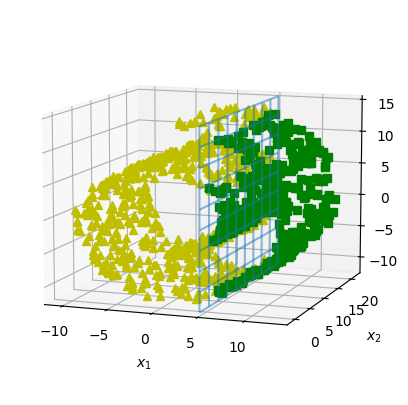

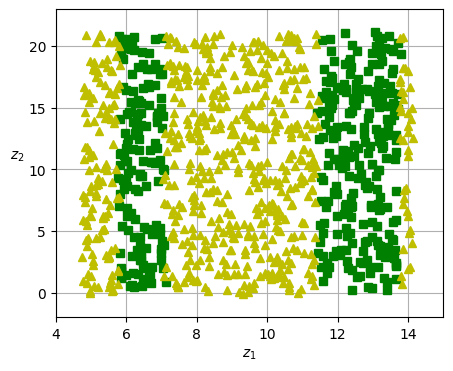

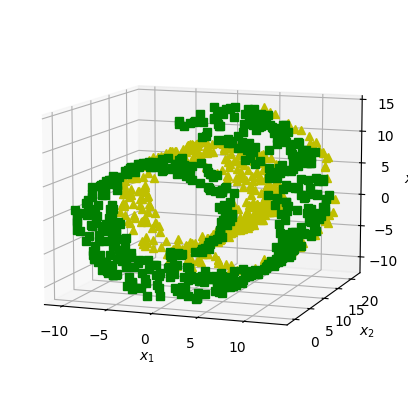

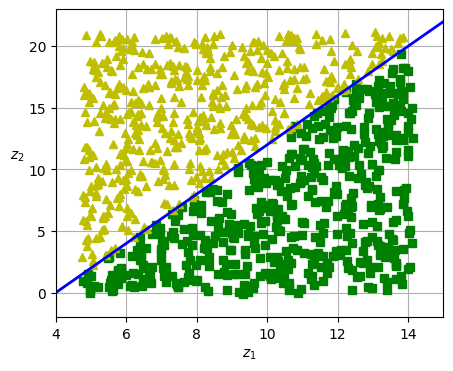

In [8]:
# extra code – this cell generates and saves plots for Figure 8–6

axes = [-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

positive_class = X_swiss[:, 0] > 5
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
set_xyz_axes(ax, axes)
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)
plt.show()

positive_class = 2 * (t[:] - 4) > X_swiss[:, 1]
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x_1$", rotation=0)
ax.set_ylabel("$x_2$", rotation=0)
ax.set_zlabel("$x_3$", rotation=0)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.plot([4, 15], [0, 22], "b-", linewidth=2)
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)
plt.show()

# Figure 8-6. The decision boundary may not always be simpler with lower dimensions

# PCA
Principal component analysis (PCA) is by far the most popular dimensionality reduction algorithm. First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it, just like in Figure 8-2.

# PRESERVING THE VARIANCE
Before you can project the training set onto a lower-dimensional hyperplane, you first need to choose the right hyperplane. For example, a simple 2D dataset is represented on the left in Figure 8-7, along with three different axes (i.e., 1D hyperplanes). On the right is the result of the projection of the dataset onto each of these axes. As you can see, the projection onto the solid line preserves the maximum variance (top), while the projection onto the dotted line preserves very little variance (bottom) and the projection onto the dashed line preserves an intermediate amount of variance (middle).

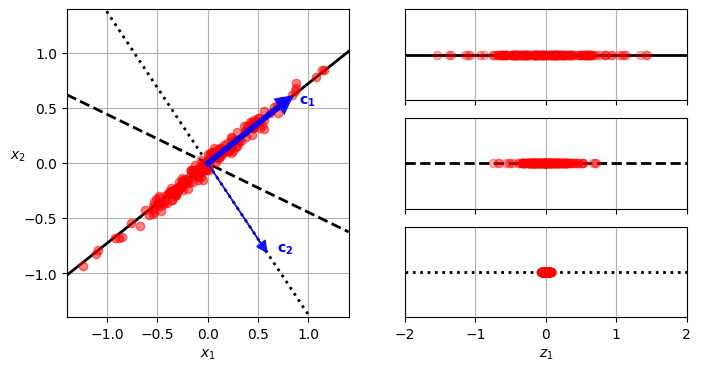

In [9]:
# extra code – this cell generates and saves Figure 8–7

angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X_line = np.random.randn(m, 2) / 10
X_line = X_line @ np.array([[stretch, 0], [0, 1]])  # stretch
X_line = X_line @ [[np.cos(angle), np.sin(angle)],
                   [np.sin(angle), np.cos(angle)]]  # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X_line @ u1.reshape(-1, 1)
X_proj2 = X_line @ u2.reshape(-1, 1)
X_proj3 = X_line @ u3.reshape(-1, 1)

plt.figure(figsize=(8, 4))
plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:",
         linewidth=2)
plt.plot(X_line[:, 0], X_line[:, 1], "ro", alpha=0.5)
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=4, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=1, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", color="blue")
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", color="blue")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.grid()

plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=2)
plt.plot(X_proj1[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=2)
plt.plot(X_proj2[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$")
plt.grid()

plt.show()

# Figure 8-7. Selecting the subspace on which to project

It seems reasonable to select the axis that preserves the maximum amount of variance, as it will most likely lose less information than the other projections. Another way to justify this choice is that it is the axis that minimizes the mean squared distance between the original dataset and its projection onto that axis. This is the rather simple idea behind PCA.

# PRINCIPAL COMPONENTS
PCA identifies the axis that accounts for the largest amount of variance in the training set. In Figure 8-7, it is the solid line. It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of the remaining variance. In this 2D example there is no choice: it is the dotted line. If it were a higher-dimensional dataset, PCA would also find a third axis, orthogonal to both previous axes, and a fourth, a fifth, and so on—as many axes as the number of dimensions in the dataset.

The $i^{th}$ axis is called the $i^{th}$ principal component (PC) of the data. In Figure 8-7, the first PC is the axis on which vector $c_1$ lies, and the second PC is the axis on which vector $c_2$ lies. In Figure 8-2 the first two PCs are on the projection plane, and the third PC is the axis orthogonal to that plane. After the projection, in Figure 8-3, the first PC corresponds to the $z_1$ axis, and the second PC corresponds to the $z_2$ axis.

NOTE
For each principal component, PCA finds a zero-centered unit vector pointing in the direction of the PC. Since two opposing unit vectors lie on the same axis, the direction of the unit vectors returned by PCA is not stable: if you perturb the training set slightly and run PCA again, the unit vectors may point in the opposite direction as the original vectors. However, they will generally still lie on the same axes. In some cases, a pair of unit vectors may even rotate or swap (if the variances along these two axes are very close), but the plane they define will generally remain the same.

So how can you find the principal components of a training set? Luckily, there is a standard matrix factorization technique called singular value decomposition (SVD) that can decompose the training set matrix $\mathbf{X}$ into the matrix multiplication of three matrices $\mathbf{U} \Sigma \mathbf{V}^T$, where $\mathbf{V}$ contains the unit vectors that define all the principal components that you are looking for, as shown in Equation 8-1.


Equation 8-1. Principal components matrix

$\mathbf{V} = \begin{bmatrix} | & | & & | \\ \mathbf{c}_1 & \mathbf{c}_2 & \cdots & \mathbf{c}_n \\ | & | & & | \end{bmatrix}$

The following Python code uses NumPy’s svd() function to obtain all the principal components of the 3D training set represented in Figure 8-2, then it extracts the two unit vectors that define the first two PCs:

In [10]:
import numpy as np

# X = [...]  # create a small 3D dataset
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

Note: in principle, the SVD factorization algorithm returns three matrices, $U$, $\Sigma$ and $V$, such that $X = U \Sigma V^\intercal$, where $U$ is an $m \times m$ matrix, $\Sigma$ is an $m \times n$ matrix, and $V$ is an $n \times n$ matrix. But the `svd()` function returns $U$, $s$ and $V^\intercal$ instead. $s$ is the vector containing all the values on the main diagonal of the top $n$ rows of $\Sigma$. Since $\Sigma$ is full of zeros elsewhere, you can easily reconstruct it from $s$, like this:


In [11]:
# extra code – shows how to construct Σ from s
m, n = X.shape
Σ = np.zeros_like(X_centered)
Σ[:n, :n] = np.diag(s)
assert np.allclose(X_centered, U @ Σ @ Vt)

WARNING
PCA assumes that the dataset is centered around the origin. As you will see, Scikit-Learn’s PCA classes take care of centering the data for you. If you implement PCA yourself (as in the preceding example), or if you use other libraries, don’t forget to center the data first.

# PROJECTING DOWN TO d DIMENSIONS

Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to $d$ dimensions by projecting it onto the hyperplane defined by the first $d$ principal components. Selecting this hyperplane ensures that the projection will preserve as much variance as possible. For example, in Figure 8-2 the 3D dataset is projected down to the 2D plane defined by the first two principal components, preserving a large part of the dataset’s variance. As a result, the 2D projection looks very much like the original 3D dataset.

To project the training set onto the hyperplane and obtain a reduced dataset $X_{d-proj}$ of dimensionality $d$, compute the matrix multiplication of the training set matrix $X$ by the matrix $W_d$, defined as the matrix containing the first $d$ columns of $V$, as shown in Equation 8-2.

Equation 8-2. Projecting the training set down to d dimensions

$X_{d-proj} = X \cdot W_d$

The following Python code projects the training set onto the plane defined by the first two principal components:

In [12]:
W2 = Vt[:2].T
X2D = X_centered @ W2

There you have it! You now know how to reduce the dimensionality of any dataset by projecting it down to any number of dimensions, while preserving as much variance as possible.

# USING SCIKIT-LEARN
Scikit-Learn’s PCA class uses SVD to implement PCA, just like we did earlier in this chapter. The following code applies PCA to reduce the dimensionality of the dataset down to two dimensions (note that it automatically takes care of centering the data):

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

After fitting the PCA transformer to the dataset, its components_ attribute holds the transpose of $W_d$: it contains one row for each of the first $d$ principal components.

In [14]:
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

# EXPLAINED VARIANCE RATIO
Another useful piece of information is the explained variance ratio of each principal component, available via the explained_variance_ratio_ variable. The ratio indicates the proportion of the dataset’s variance that lies along each principal component. For example, let’s look at the explained variance ratios of the first two components of the 3D dataset represented in Figure 8-2:

In [15]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

This output tells us that about 76% of the dataset’s variance lies along the first PC, and about 15% lies along the second PC. This leaves about 9% for the third PC, so it is reasonable to assume that the third PC probably carries little information.

In [16]:
# By projecting down to 2D, we lost about 9% of the variance:
1 - pca.explained_variance_ratio_.sum()  # extra code

0.09028309326742046

# CHOOSING THE RIGHT NUMBER OF DIMENSIONS
Instead of arbitrarily choosing the number of dimensions to reduce down to, it is simpler to choose the number of dimensions that add up to a sufficiently large portion of the variance—say, 95% (An exception to this rule, of course, is if you are reducing dimensionality for data visualization, in which case you will want to reduce the dimensionality down to 2 or 3).

The following code loads and splits the MNIST dataset (introduced in Chapter 3) and performs PCA without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of the training set’s variance:

In [17]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # d equals 154

# Note: I added parser="auto" when calling fetch_openml() to avoid a warning about the fact that the default value for that parameter will change in the future (it's irrelevant in this case). Please see the documentation for more details.

In [18]:
d

154

You could then set n_components=d and run PCA again, but there’s a better option. Instead of specifying the number of principal components you want to preserve, you can set n_components to be a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve:

In [19]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

The actual number of components is determined during training, and it is stored in the n_components_ attribute:

In [20]:
pca.n_components_

154

Yet another option is to plot the explained variance as a function of the number of dimensions (simply plot cumsum; see Figure 8-8). There will usually be an elbow in the curve, where the explained variance stops growing fast. In this case, you can see that reducing the dimensionality down to about 100 dimensions wouldn’t lose too much explained variance.

In [21]:
pca.explained_variance_ratio_.sum()  # extra code

0.9501960192613031

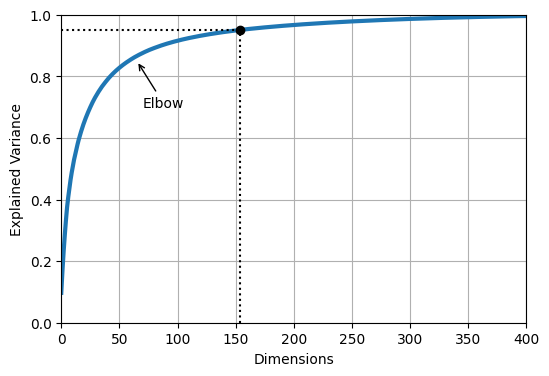

In [22]:
# extra code – this cell generates and saves Figure 8–8

plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)

plt.show()

# Figure 8-8. Explained variance as a function of the number of dimensions

Lastly, if you are using dimensionality reduction as a preprocessing step for a supervised learning task (e.g., classification), then you can tune the number of dimensions as you would any other hyperparameter (see Chapter 2). For example, the following code example creates a two-step pipeline, first reducing dimensionality using PCA, then classifying using a random forest. Next, it uses RandomizedSearchCV to find a good combination of hyperparameters for both PCA and the random forest classifier. This example does a quick search, tuning only 2 hyperparameters, training on just 1,000 instances, and running for just 10 iterations, but feel free to do a more thorough search if you have the time:

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

Let’s look at the best hyperparameters found:

In [24]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}


It’s interesting to note how low the optimal number of components is: we reduced a 784-dimensional dataset to just 23 dimensions! This is tied to the fact that we used a random forest, which is a pretty powerful model. If we used a linear model instead, such as an SGDClassifier, the search would find that we need to preserve more dimensions (about 70).

In [25]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

clf = make_pipeline(PCA(random_state=42), SGDClassifier())
param_grid = {"pca__n_components": np.arange(10, 80)}
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])})

In [26]:
grid_search.best_params_

{'pca__n_components': 67}

# PCA FOR COMPRESSION
After dimensionality reduction, the training set takes up much less space. For example, after applying PCA to the MNIST dataset while preserving 95% of its variance, we are left with 154 features, instead of the original 784 features. So the dataset is now less than 20% of its original size, and we only lost 5% of its variance! This is a reasonable compression ratio, and it’s easy to see how such a size reduction would speed up a classification algorithm tremendously.

It is also possible to decompress the reduced dataset back to 784 dimensions by applying the inverse transformation of the PCA projection. This won’t give you back the original data, since the projection lost a bit of information (within the 5% variance that was dropped), but it will likely be close to the original data. The mean squared distance between the original data and the reconstructed data (compressed and then decompressed) is called the reconstruction error.

The inverse_transform() method lets us decompress the reduced MNIST dataset back to 784 dimensions:

In [27]:

pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)

In [28]:
X_recovered = pca.inverse_transform(X_reduced)

Figure 8-9 shows a few digits from the original training set (on the left), and the corresponding digits after compression and decompression. You can see that there is a slight image quality loss, but the digits are still mostly intact.

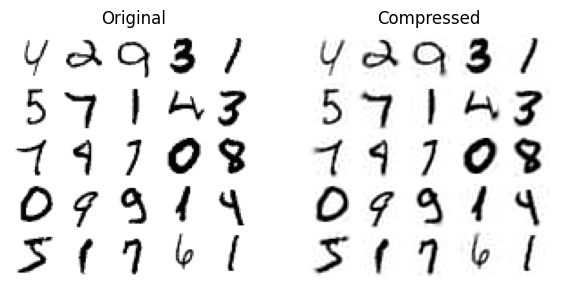

In [29]:
# extra code – this cell generates and saves Figure 8–9

plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")


# Figure 8-9. MNIST compression that preserves 95% of the variance

The equation for the inverse transformation is shown in Equation 8-3.

Equation 8-3. PCA inverse transformation, back to the original number of dimensions

$X_{\text{recovered}} = X_{d\text{-proj}} \cdot W_d^T$

# RANDOMIZED PCA
If you set the svd_solver hyperparameter to "randomized", Scikit-Learn uses a stochastic algorithm called randomized PCA that quickly finds an approximation of the first $d$ principal components. Its computational complexity is $O(m × d^2) + O(d^3)$, instead of $O(m × n^2) + O(n^3)$ for the full SVD approach, so it is dramatically faster than full SVD when $d$ is much smaller than $n$:

In [30]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

TIP
By default, svd_solver is actually set to "auto": Scikit-Learn automatically uses the randomized PCA algorithm if $max(m, n) > 500$ and n_components is an integer smaller than 80% of $min(m, n)$, or else it uses the full SVD approach. So the preceding code would use the randomized PCA algorithm even if you removed the svd_solver="randomized" argument, since $154 < 0.8 × 784$. If you want to force Scikit-Learn to use full SVD for a slightly more precise result, you can set the svd_solver hyperparameter to "full".

# INCREMENTAL PCA
One problem with the preceding implementations of PCA is that they require the whole training set to fit in memory in order for the algorithm to run. Fortunately, incremental PCA (IPCA) algorithms have been developed that allow you to split the training set into mini-batches and feed these in one mini-batch at a time. This is useful for large training sets and for applying PCA online (i.e., on the fly, as new instances arrive).

The following code splits the MNIST training set into 100 mini-batches (using NumPy’s array_split() function) and feeds them to Scikit-Learn’s IncrementalPCA class⁠5 to reduce the dimensionality of the MNIST dataset down to 154 dimensions, just like before. Note that you must call the partial_fit() method with each mini-batch, rather than the fit() method with the whole training set:

In [31]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

Alternatively, you can use NumPy’s memmap class, which allows you to manipulate a large array stored in a binary file on disk as if it were entirely in memory; the class loads only the data it needs in memory, when it needs it. To demonstrate this, let’s first create a memory-mapped (memmap) file and copy the MNIST training set to it, then call flush() to ensure that any data still in the cache gets saved to disk. In real life, X_train would typically not fit in memory, so you would load it chunk by chunk and save each chunk to the right part of the memmap array:

In [32]:
import os

# check if the my_mnist.mmap file is in "saved_datasets/MNIST/" directory:
os.path.isfile("saved_datasets/MNIST/my_mnist.mmap")

True

In [33]:
# Let's create the memmap instance, copy the MNIST training set into it, and call flush() which ensures that any data still in cache is saved to disk. This would typically be done by a first program:
path_to_my_mnist = "saved_datasets/MNIST/my_mnist.mmap"
if not os.path.isfile(path_to_my_mnist):
    X_mmap = np.memmap(
        path_to_my_mnist,
        dtype='float32',
        mode='write',
        shape=X_train.shape
    )
    X_mmap[:] = X_train  # could be a loop instead, saving the data chunk by chunk
    X_mmap.flush()

Next, we can load the memmap file and use it like a regular NumPy array. Let’s use the IncrementalPCA class to reduce its dimensionality. Since this algorithm uses only a small part of the array at any given time, memory usage remains under control. This makes it possible to call the usual fit() method instead of partial_fit(), which is quite convenient:

In [34]:
X_mmap = np.memmap(
    path_to_my_mnist,
    dtype="float32",
    mode="readonly"
).reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

WARNING
Only the raw binary data is saved to disk, so you need to specify the data type and shape of the array when you load it. If you omit the shape, np.memmap() returns a 1D array.

For very high-dimensional datasets, PCA can be too slow. As you saw earlier, even if you use randomized PCA its computational complexity is still $O(m × d^2) + O(d^3)$, so the target number of dimensions d must not be too large. If you are dealing with a dataset with tens of thousands of features or more (e.g., images), then training may become much too slow: in this case, you should consider using random projection instead.

# RANDOM PROJECTION
As its name suggests, the random projection algorithm projects the data to a lower-dimensional space using a random linear projection. This may sound crazy, but it turns out that such a random projection is actually very likely to preserve distances fairly well, as was demonstrated mathematically by William B. Johnson and Joram Lindenstrauss in a famous lemma. So, two similar instances will remain similar after the projection, and two very different instances will remain very different.

Obviously, the more dimensions you drop, the more information is lost, and the more distances get distorted. So how can you choose the optimal number of dimensions? Well, Johnson and Lindenstrauss came up with an equation that determines the minimum number of dimensions to preserve in order to ensure—with high probability—that distances won’t change by more than a given tolerance. For example, if you have a dataset containing $m = 5000$ instances with $n = 20000$ features each, and you don’t want the squared distance between any two instances to change by more than ε = 10%, then you should project the data down to $d$ dimensions, with $d ≥ 4 log(m) / (½ ε² - ⅓ ε³)$, which is $7300$ dimensions. That’s quite a significant dimensionality reduction! Notice that the equation does not use $n$, it only relies on $m$ and ε. This equation is implemented by the johnson_lindenstrauss_min_dim() function:

In [35]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, ε = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=ε)
d

7300

In [36]:
# extra code – show the equation computed by johnson_lindenstrauss_min_dim
d = int(4 * np.log(m) / (ε ** 2 / 2 - ε ** 3 / 3))
d

7300

Now we can just generate a random matrix $P$ of shape $[d, n]$, where each item is sampled randomly from a Gaussian distribution with mean 0 and variance $1 / d$, and use it to project a dataset from $n$ dimensions down to $d$:

In [37]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d)  # std dev = square root of variance

X = np.random.randn(m, n)  # generate a fake dataset
X_reduced = X @ P.T

That’s all there is to it! It’s simple and efficient, and no training is required: the only thing the algorithm needs to create the random matrix is the dataset’s shape. The data itself is not used at all.

Scikit-Learn offers a GaussianRandomProjection class to do exactly what we just did: when you call its fit() method, it uses johnson_lindenstrauss_min_dim() to determine the output dimensionality, then it generates a random matrix, which it stores in the components_ attribute. Then when you call transform(), it uses this matrix to perform the projection. When creating the transformer, you can set 'eps' if you want to tweak ε (it defaults to 0.1), and n_components if you want to force a specific target dimensionality $d$. The following code example gives the same result as the preceding code (you can also verify that gaussian_rnd_proj.components_ is equal to $P$):

In [38]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=ε, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)  # same result as above

Scikit-Learn also provides a second random projection transformer, known as SparseRandomProjection. It determines the target dimensionality in the same way, generates a random matrix of the same shape, and performs the projection identically. The main difference is that the random matrix is sparse. This means it uses much less memory: about 25 MB instead of almost 1.2 GB in the preceding example! And it’s also much faster, both to generate the random matrix and to reduce dimensionality: about 50% faster in this case. Moreover, if the input is sparse, the transformation keeps it sparse (unless you set dense_output=True). Lastly, it enjoys the same distance-preserving property as the previous approach, and the quality of the dimensionality reduction is comparable. In short, it’s usually preferable to use this transformer instead of the first one, especially for large or sparse datasets.

The ratio $r$ of nonzero items in the sparse random matrix is called its density. By default, it is equal to $\frac{1}{\sqrt{n}}$. With 20,000 features, this means that only 1 in ~141 cells in the random matrix is nonzero: that’s quite sparse! You can set the density hyperparameter to another value if you prefer. Each cell in the sparse random matrix has a probability $r$ of being nonzero, and each nonzero value is either $–v$ or $+v$ (both equally likely), where $v = \frac{1}{\sqrt{dr}}$ 
.

If you want to perform the inverse transform, you first need to compute the pseudo-inverse of the components matrix using SciPy’s pinv() function, then multiply the reduced data by the transpose of the pseudo-inverse:

In [39]:
# FYI: takes 2 minutes to run
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

WARNING
Computing the pseudo-inverse may take a very long time if the components matrix is large, as the computational complexity of 'pinv()' is $O(dn²)$ if $d < n$, or $O(nd²)$ otherwise.

In summary, random projection is a simple, fast, memory-efficient, and surprisingly powerful dimensionality reduction algorithm that you should keep in mind, especially when you deal with high-dimensional datasets.

NOTE
Random projection is not always used to reduce the dimensionality of large datasets. For example, a 2017 paper by Sanjoy Dasgupta et al. showed that the brain of a fruit fly implements an analog of random projection to map dense low-dimensional olfactory inputs to sparse high-dimensional binary outputs: for each odor, only a small fraction of the output neurons get activated, but similar odors activate many of the same neurons. This is similar to a well-known algorithm called locality sensitive hashing (LSH), which is typically used in search engines to group similar documents.

In [40]:
# extra code – performance comparison between Gaussian and Sparse RP

from sklearn.random_projection import SparseRandomProjection

print("GaussianRandomProjection fit")
%timeit GaussianRandomProjection(random_state=42).fit(X)
print("SparseRandomProjection fit")
%timeit SparseRandomProjection(random_state=42).fit(X)

gaussian_rnd_proj = GaussianRandomProjection(random_state=42).fit(X)
sparse_rnd_proj = SparseRandomProjection(random_state=42).fit(X)
print("GaussianRandomProjection transform")
%timeit gaussian_rnd_proj.transform(X)
print("SparseRandomProjection transform")
%timeit sparse_rnd_proj.transform(X)

GaussianRandomProjection fit
3.06 s ± 79.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection fit
1.99 s ± 27.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GaussianRandomProjection transform
3.97 s ± 132 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection transform
3.49 s ± 120 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# LLE
Locally linear embedding (LLE) is a nonlinear dimensionality reduction (NLDR) technique. It is a manifold learning technique that does not rely on projections, unlike PCA and random projection. In a nutshell, LLE works by first measuring how each training instance linearly relates to its nearest neighbors, and then looking for a low-dimensional representation of the training set where these local relationships are best preserved (more details shortly). This approach makes it particularly good at unrolling twisted manifolds, especially when there is not too much noise.

The following code makes a Swiss roll, then uses Scikit-Learn’s LocallyLinearEmbedding class to unroll it:

In [41]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

The variable $t$ is a 1D NumPy array containing the position of each instance along the rolled axis of the Swiss roll. We don’t use it in this example, but it can be used as a target for a nonlinear regression task.

The resulting 2D dataset is shown in Figure 8-10. As you can see, the Swiss roll is completely unrolled, and the distances between instances are locally well preserved. However, distances are not preserved on a larger scale: the unrolled Swiss roll should be a rectangle, not this kind of stretched and twisted band. Nevertheless, LLE did a pretty good job of modeling the manifold.

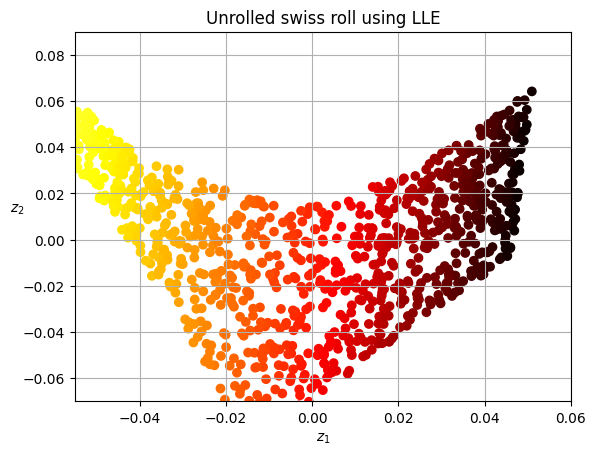

In [42]:
# extra code – this cell generates and saves Figure 8–10

plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

plt.title("Unrolled swiss roll using LLE")
plt.show()
# Figure 8-10. Unrolled Swiss roll using LLE

Here’s how LLE works: for each training instance $x^{(i)}$, the algorithm identifies its k-nearest neighbors (in the preceding code k = 10), then tries to reconstruct $x^{(i)}$ as a linear function of these neighbors. More specifically, it tries to find the weights $w_{i,j}$ such that the squared distance between $x^{(i)}$ and $\sum_{j=1}^m w_{i,j}x^{(j)}$ is as small as possible, assuming $w_{i,j} = 0$ if $x^{(j)}$ is not one of the k-nearest neighbors of $x^{(i)}$. Thus the first step of LLE is the constrained optimization problem described in Equation 8-4, where $W$ is the weight matrix containing all the weights $w_{i,j}$. The second constraint simply normalizes the weights for each training instance $x^{(i)}$.

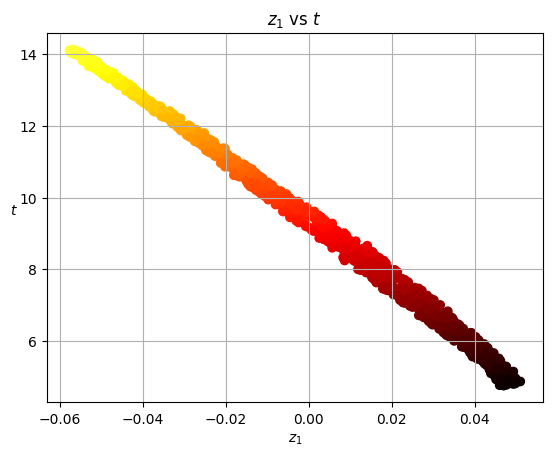

In [43]:
# extra code – shows how well correlated z1 is to t: LLE worked fine
plt.title("$z_1$ vs $t$")
plt.scatter(X_unrolled[:, 0], t, c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$t$", rotation=0)
plt.grid(True)
plt.show()

Equation 8-4. LLE step 1: linearly modeling local relationships

$\hat{W} = \, \underset{\mathbf{W}}{\text{argmin}} \sum_{i=1}^m \left( x^{(i)} - \sum_{j=1}^m w_{i,j}x^{(j)} \right)^2$

subject to
$\begin{cases} w_{i,j} = 0 & \text{if } x^{(j)} \text{ is not one of the k-nearest neighbors of } x^{(i)} \\ \sum_{j=1}^m w_{i,j} = 1 & \text{for } i = 1, 2, \ldots, m \end{cases}$

After this step, the weight matrix $\hat{W}$ (containing the weights $\hat{w_{i,j}}$) encodes the local linear relationships between the training instances. The second step is to map the training instances into a $d$-dimensional space (where $d < n$) while preserving these local relationships as much as possible. If $z^{(i)}$ is the image of $x^{(i)}$ in this d-dimensional space, then we want the squared distance between $z^{(i)}$ and $\sum_{j=1}^m \, \hat{w}_{i,j}z^{(j)}$ to be as small as possible. This idea leads to the unconstrained optimization problem described in Equation 8-5. It looks very similar to the first step, but instead of keeping the instances fixed and finding the optimal weights, we are doing the reverse: keeping the weights fixed and finding the optimal position of the instances’ images in the low-dimensional space. Note that $Z$ is the matrix containing all $z^{(i)}$.

Equation 8-5. LLE step 2: reducing dimensionality while preserving relationships

$\hat{Z} = \, \underset{\mathbf{Z}}{\text{argmin}} \sum_{i=1}^m \left( z^{(i)} - \sum_{j=1}^m \hat{w}_{i,j}z^{(j)} \right)^2$

Scikit-Learn’s LLE implementation has the following computational complexity: $O(m \, log(m)n \, log(k))$ for finding the k-nearest neighbors, $O(mnk^3)$ for optimizing the weights, and $O(dm^2)$ for constructing the low-dimensional representations. Unfortunately, the $m^2$ in the last term makes this algorithm scale poorly to very large datasets.

As you can see, LLE is quite different from the projection techniques, and it’s significantly more complex, but it can also construct much better low-dimensional representations, especially if the data is nonlinear.

# OTHER DIMENSIONALITY REDUCTION TECHNIQUES
Before we conclude this chapter, let’s take a quick look at a few other popular dimensionality reduction techniques available in Scikit-Learn:

**sklearn.manifold.MDS**
Multidimensional scaling (MDS) reduces dimensionality while trying to preserve the distances between the instances. Random projection does that for high-dimensional data, but it doesn’t work well on low-dimensional data.

**sklearn.manifold.Isomap**
Isomap creates a graph by connecting each instance to its nearest neighbors, then reduces dimensionality while trying to preserve the geodesic distances between the instances. The geodesic distance between two nodes in a graph is the number of nodes on the shortest path between these nodes.

**sklearn.manifold.TSNE**
t-distributed stochastic neighbor embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space. For example, in the exercises at the end of this chapter you will use t-SNE to visualize a 2D map of the MNIST images.

**sklearn.discriminant_analysis.LinearDiscriminantAnalysis**
Linear discriminant analysis (LDA) is a linear classification algorithm that, during training, learns the most discriminative axes between the classes. These axes can then be used to define a hyperplane onto which to project the data. The benefit of this approach is that the projection will keep classes as far apart as possible, so LDA is a good technique to reduce dimensionality before running another classification algorithm (unless LDA alone is sufficient).

Figure 8-11 shows the results of MDS, Isomap, and t-SNE on the Swiss roll. MDS manages to flatten the Swiss roll without losing its global curvature, while Isomap drops it entirely. Depending on the downstream task, preserving the large-scale structure may be good or bad. t-SNE does a reasonable job of flattening the Swiss roll, preserving a bit of curvature, and it also amplifies clusters, tearing the roll apart. Again, this might be good or bad, depending on the downstream task.

In [44]:
# Note: I added normalized_stress=False below to avoid a warning about the fact that the default value for that hyperparameter will change in the future. Please see the documentation for more details.

from sklearn.manifold import MDS

mds = MDS(n_components=2, normalized_stress=False, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

In [45]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

In [46]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

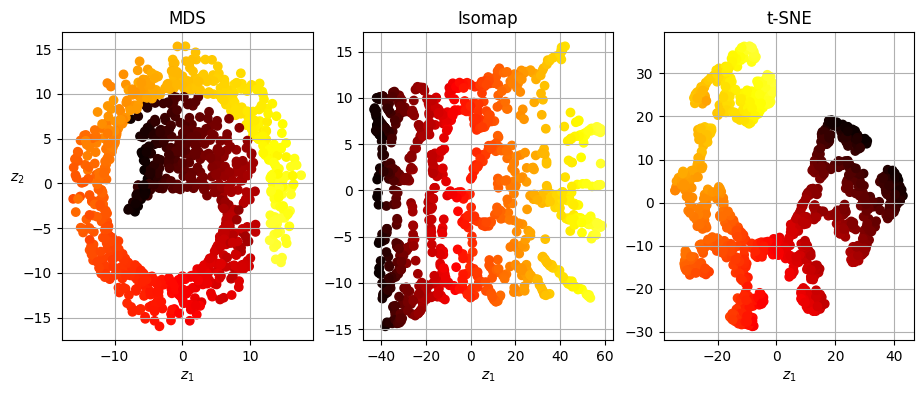

In [47]:
# extra code – this cell generates and saves Figure 8–11

titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)

plt.show()

# Figure 8-11. Using various techniques to reduce the Swiss roll to 2D

# KERNEL PCA


In [48]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04, random_state=42)
X_reduced = rbf_pca.fit_transform(X_swiss)

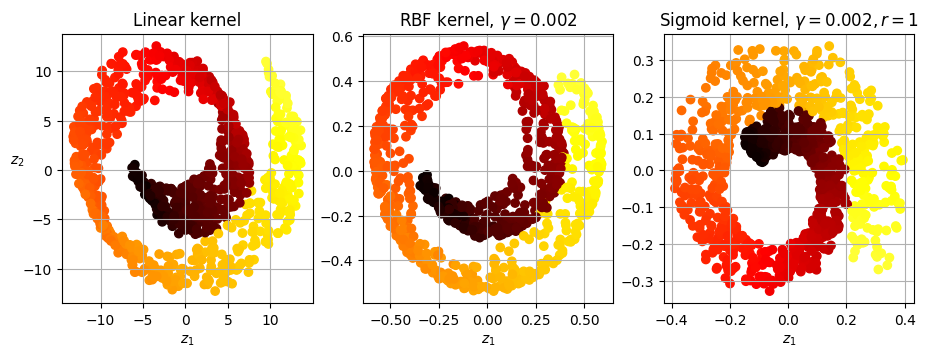

In [49]:
lin_pca = KernelPCA(kernel="linear")
rbf_pca = KernelPCA(kernel="rbf", gamma=0.002)
sig_pca = KernelPCA(kernel="sigmoid", gamma=0.002, coef0=1)

kernel_pcas = ((lin_pca, "Linear kernel"),
               (rbf_pca, rf"RBF kernel, $\gamma={rbf_pca.gamma}$"),
               (sig_pca, rf"Sigmoid kernel, $\gamma={sig_pca.gamma}, r={sig_pca.coef0}$"))

plt.figure(figsize=(11, 3.5))
for idx, (kpca, title) in enumerate(kernel_pcas):
    kpca.n_components = 2
    kpca.random_state = 42
    X_reduced = kpca.fit_transform(X_swiss)

    plt.subplot(1, 3, idx + 1)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if idx == 0:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid()

plt.show()

# EXTRA MATERIALS / EXERCIES
1. The main motivations for dimensionality reduction are:

- To speed up a subsequent training algorithm (in some cases it may even remove noise and redundant features, making the training algorithm perform better)
- To visualize the data and gain insights on the most important features
- To save space (compression)

______The main drawbacks are:
- Some information is lost, possibly degrading the performance of subsequent training algorithms.
- It can be computationally intensive.
- It adds some complexity to your Machine Learning pipelines.
- Transformed features are often hard to interpret.
2. The curse of dimensionality refers to the fact that many problems that do not exist in low-dimensional space arise in high-dimensional space. In Machine Learning, one common manifestation is the fact that randomly sampled high-dimensional vectors are generally far from one another, increasing the risk of overfitting and making it very difficult to identify patterns without having plenty of training data.

3. Once a dataset's dimensionality has been reduced using one of the algorithms we discussed, it is almost always impossible to perfectly reverse the operation, because some information gets lost during dimensionality reduction. Moreover, while some algorithms (such as PCA) have a simple reverse transformation procedure that can reconstruct a dataset relatively similar to the original, other algorithms (such as t-SNE) do not.

4. PCA can be used to significantly reduce the dimensionality of most datasets, even if they are highly nonlinear, because it can at least get rid of useless dimensions. However, if there are no useless dimensions—as in the Swiss roll dataset—then reducing dimensionality with PCA will lose too much information. You want to unroll the Swiss roll, not squash it.

5. That's a trick question: it depends on the dataset. Let's look at two extreme examples. First, suppose the dataset is composed of points that are almost perfectly aligned. In this case, PCA can reduce the dataset down to just one dimension while still preserving 95% of the variance. Now imagine that the dataset is composed of perfectly random points, scattered all around the 1,000 dimensions. In this case roughly 950 dimensions are required to preserve 95% of the variance. So the answer is, it depends on the dataset, and it could be any number between 1 and 950. Plotting the explained variance as a function of the number of dimensions is one way to get a rough idea of the dataset's intrinsic dimensionality.

6. Regular PCA is the default, but it works only if the dataset fits in memory. Incremental PCA is useful for large datasets that don't fit in memory, but it is slower than regular PCA, so if the dataset fits in memory you should prefer regular PCA. Incremental PCA is also useful for online tasks, when you need to apply PCA on the fly, every time a new instance arrives. Randomized PCA is useful when you want to considerably reduce dimensionality and the dataset fits in memory; in this case, it is much faster than regular PCA. Finally, Random Projection is great for very high-dimensional datasets.

7. Intuitively, a dimensionality reduction algorithm performs well if it eliminates a lot of dimensions from the dataset without losing too much information. One way to measure this is to apply the reverse transformation and measure the reconstruction error. However, not all dimensionality reduction algorithms provide a reverse transformation. Alternatively, if you are using dimensionality reduction as a preprocessing step before another Machine Learning algorithm (e.g., a Random Forest classifier), then you can simply measure the performance of that second algorithm; if dimensionality reduction did not lose too much information, then the algorithm should perform just as well as when using the original dataset.

8. It can absolutely make sense to chain two different dimensionality reduction algorithms. A common example is using PCA or Random Projection to quickly get rid of a large number of useless dimensions, then applying another much slower dimensionality reduction algorithm, such as LLE. This two-step approach will likely yield roughly the same performance as using LLE only, but in a fraction of the time.

In [50]:
# TODO: DOPLINIT ZBYTEK EXTRAS Z GITHUBU